Learn iterator for multiphase elastic problems using SAC-FEANet

In [1]:
import pacnet.pac as pac

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ElasticityDataSet

In [17]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test SAC-FEANet for elastic problems

In [19]:
model_name = 'elasticity_type1_2d_33x33'
training_set = ElasticityDataSet('data/elasticity_planestress/elasticity_type1_2d_33x33.h5', device)
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 16
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

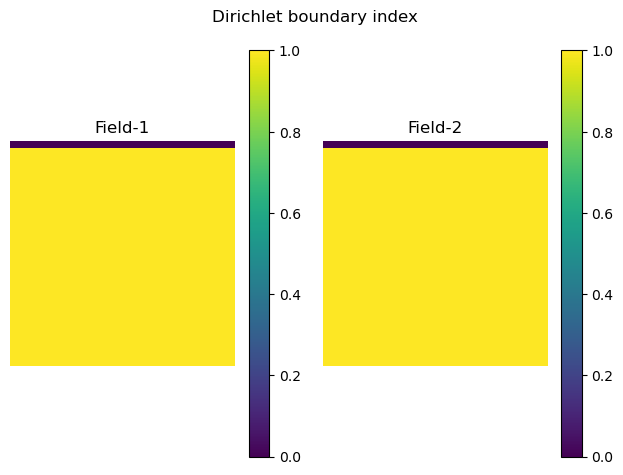

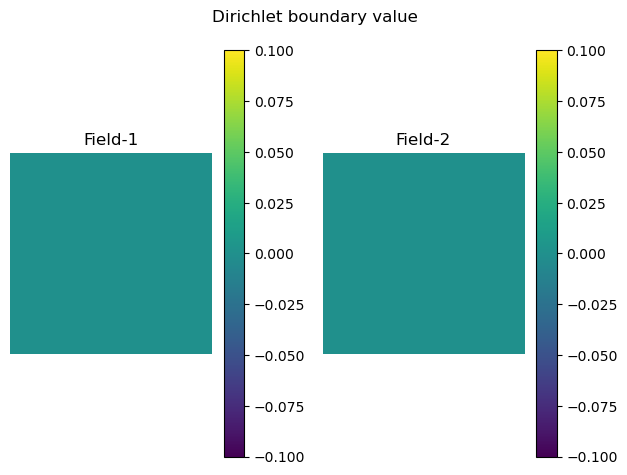

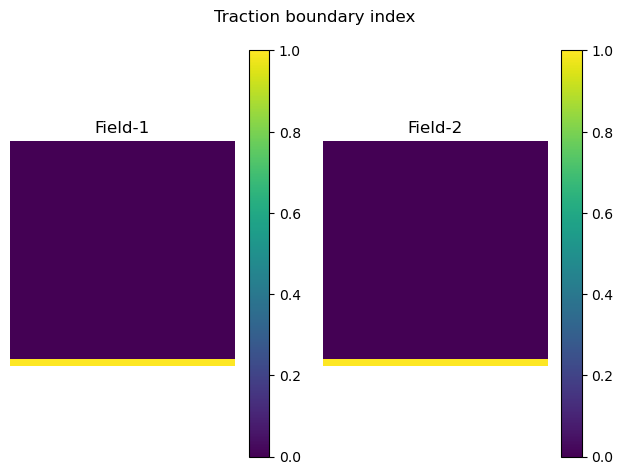

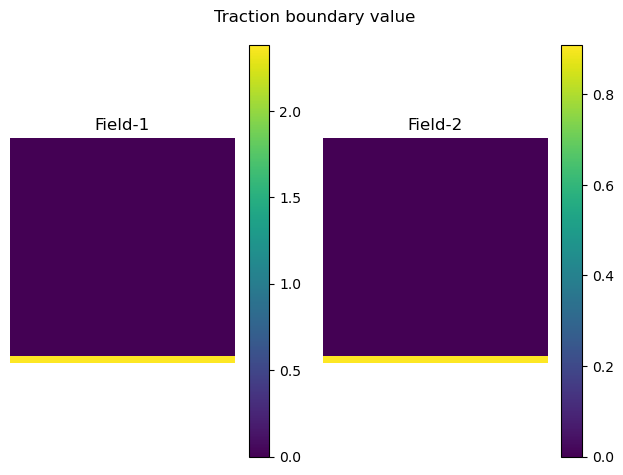

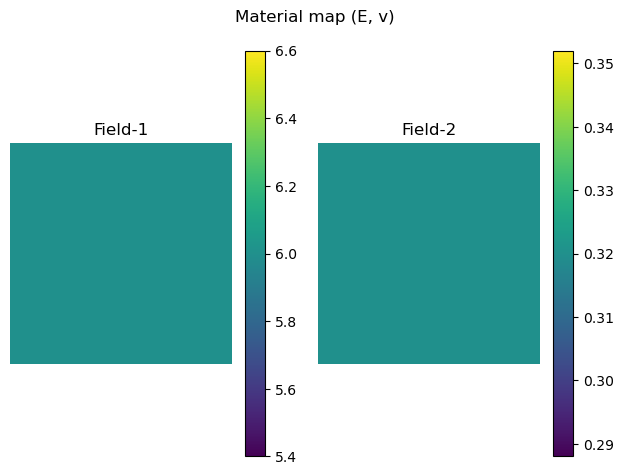

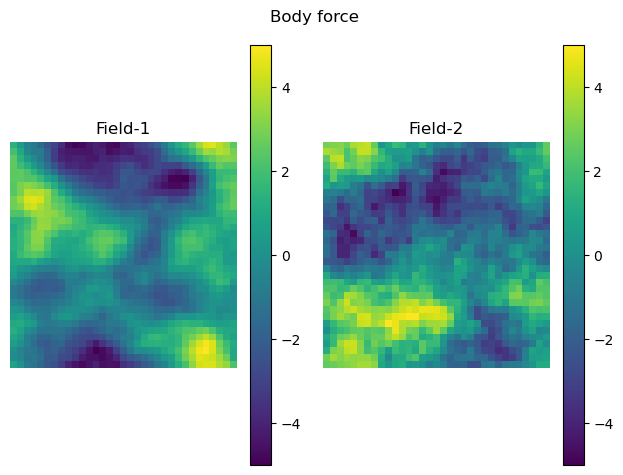

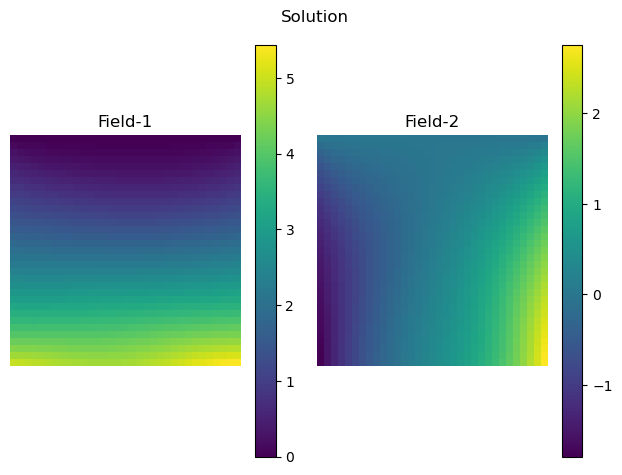

In [20]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(f_train[k], ftitle='Body force')
plot.plot_elasticfield(u_train[k], ftitle='Solution')

In [21]:
domain_size = 2
n_elem = 2**5
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic', dev=device_predict)

In [22]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [23]:
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr = [res]
print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test)
    residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')


0 39.70154956350341
1 19.527361668877003
2 14.027685903410383
3 11.24541654235384
4 9.503682569791241
5 8.290635221950692
6 7.390442919992201
7 6.692613928143253
8 6.13394434951348
9 5.67538791156203
10 5.291421460465727
11 4.964625259157112
12 4.682677622167269
13 4.4366075375803025
14 4.219718707729872
15 4.026907145641084
16 3.854210414739797
17 3.69850312614568
18 3.55728511438095
19 3.4285313355008222
20 3.310583166054107
21 3.2020684448241834
22 3.101841668175013
23 3.0089386618117895
24 2.9225417662691386
25 2.8419527939047344
26 2.7665717933263516
27 2.6958802126900103
28 2.6294274287745134
29 2.5668198795598896
30 2.5077122290162293
31 2.4518001326233847
32 2.398814273903456
33 2.3485154180021226
34 2.3006902848653508
35 2.255148087338439
36 2.2117176120733277
37 2.1702447461739234
38 2.1305903718944506
39 2.0926285668363382
40 2.0562450589737638
41 2.0213358952375997
42 1.9878062898664042
43 1.9555696247190413
44 1.9245465785610836
45 1.8946643662346025
46 1.8658560717899024


KeyboardInterrupt: 

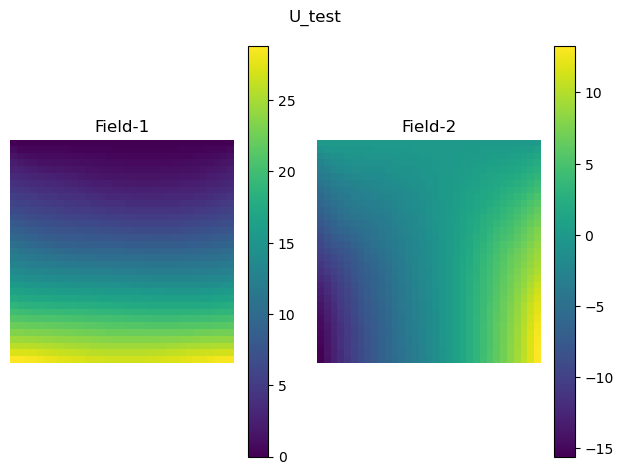

In [9]:
plot.plot_elasticfield(u_test[0], "U_test")

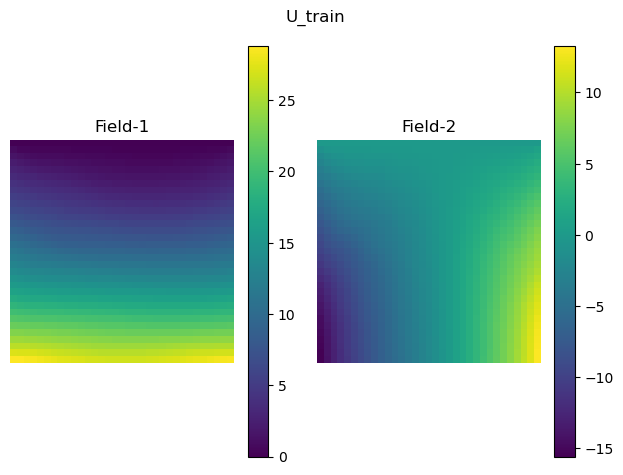

In [10]:
plot.plot_elasticfield(solution_test[0], "U_train")

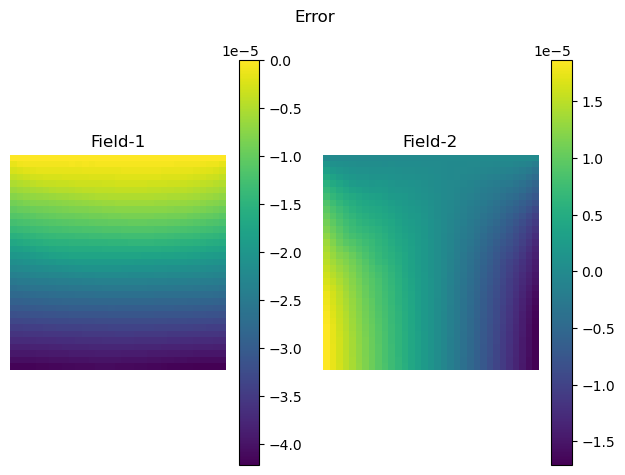

In [11]:
plot.plot_elasticfield(u_test[0]-solution_test[0], 'Error')

In [12]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''

        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [13]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=8,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, h, v, f, t, t_idx, d, d_idx, m, num_sweeps_down):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(h, u, f, t, t_idx, d, d_idx, m)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 1048047.0241064307
Step-50 loss: 1035188.6078299449
Step-100 loss: 1033254.2427614501
Step-150 loss: 1032851.1371316938
Step-200 loss: 1027055.9173145976
Step-250 loss: 1036416.2133396637
Step-300 loss: 1028281.2982883609
Step-350 loss: 1031880.0507887662
Step-400 loss: 1031060.2861809933
Step-450 loss: 1032095.6363990695
Step-500 loss: 1035269.2992548398
Step-550 loss: 1033538.4464780326
Step-600 loss: 1032464.1751703682
Step-650 loss: 1035807.551669078
Step-700 loss: 1037057.7311276483
Step-750 loss: 1027838.7522011684
Step-800 loss: 1035945.7467585399
Step-850 loss: 1035853.7731365415
Step-900 loss: 1028597.3482091078
Step-950 loss: 1034257.5454792746
Average loss:  tensor(1032658.3750) , STD:  tensor(2771.2388)


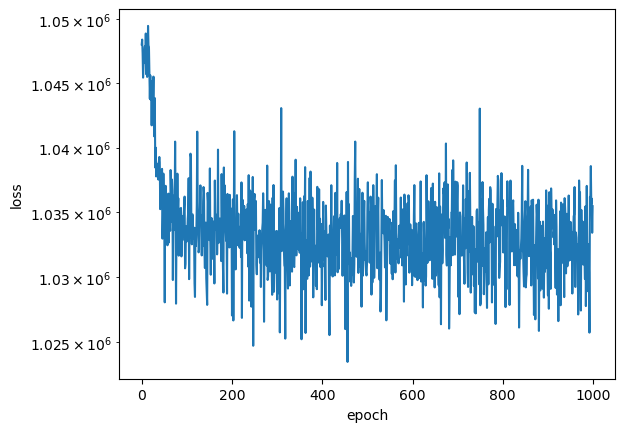

In [24]:
my_iterator = PsiIterator(device, batch_size=bs, mode='elastic')
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


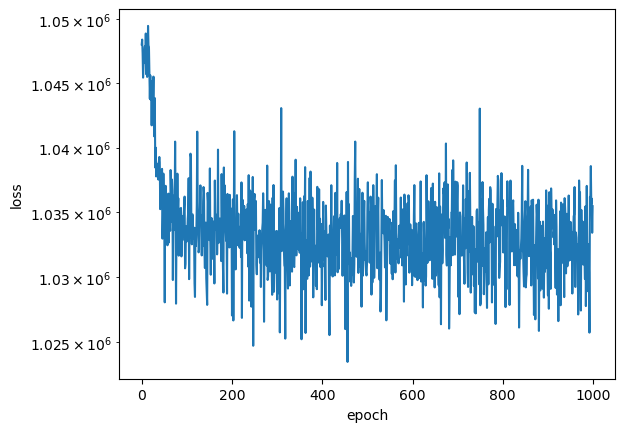

In [25]:
# import the learned model and loss train
my_net = PsiNet(mode='elastic').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, grid=grid, batch_size=1, mode='elastic')

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 18.638122706826813
1 14.708455769803608
2 12.728751242747519
3 11.62100033965911
4 10.471380601962046
5 9.28266086694209
6 8.45857933680651
7 8.329707856949224
8 8.898949467376017
9 11.639437870996659
10 17.98904638741208
11 30.571575042278955
12 53.531282880745195
13 95.56070283294557
14 171.7691236497295
15 310.36304573616627
16 562.2888512173353
17 1021.0883376577506
18 1856.736705020959
19 3378.3988669644673
20 6145.78201052629
21 11172.404977850047
22 20293.217152311845
23 36831.339555161045
24 66794.4805782522
25 121000.32851203399
26 218806.02588251609
27 394583.225332352
28 708853.995587299
29 1267290.2820173984
30 2252900.161610312
31 3980205.296788703
32 6985893.582206864
33 12179665.872867018
34 21093942.258718677
35 36295203.38878577
36 62058486.131907284
37 105468623.38480708
38 178210955.14984238
39 299472167.8553384
40 500622888.1955731
41 832751634.4833019
42 1378749623.154007
43 2272641277.3712373
44 3730425930.159203
45 6099171831.228115
46 9935001968.812777
47 1612

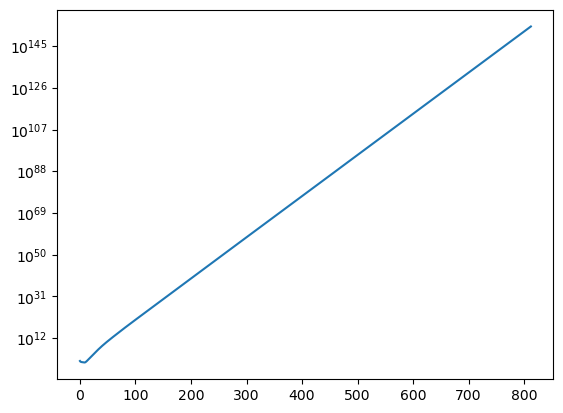

In [26]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
while (abs(res) > EPS):
    u_test = new_iterator.PsiRelax(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test, 1)
    residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr_new.append(res)
    print(n_new, res)
    n_new += 1

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new)
plt.yscale('log')
